****************************************************************************************************


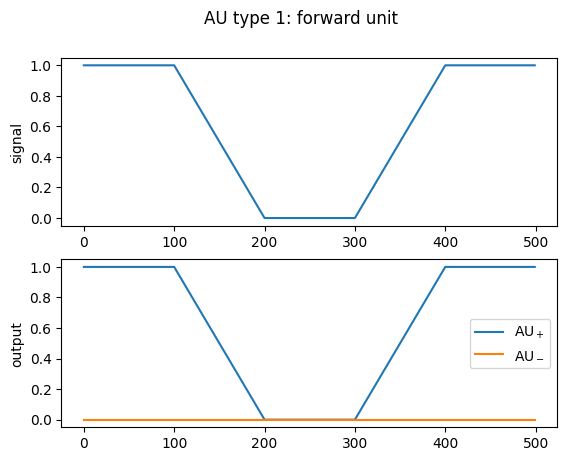

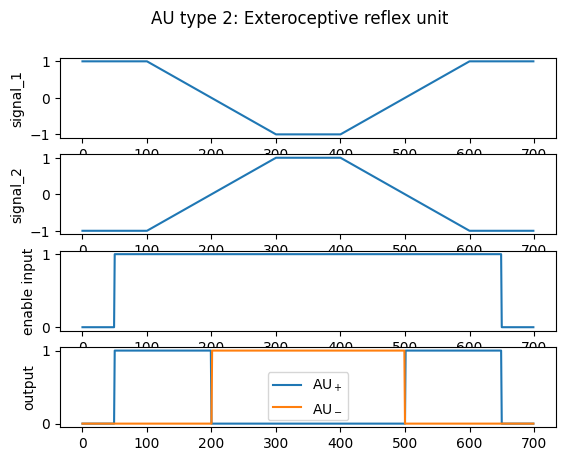

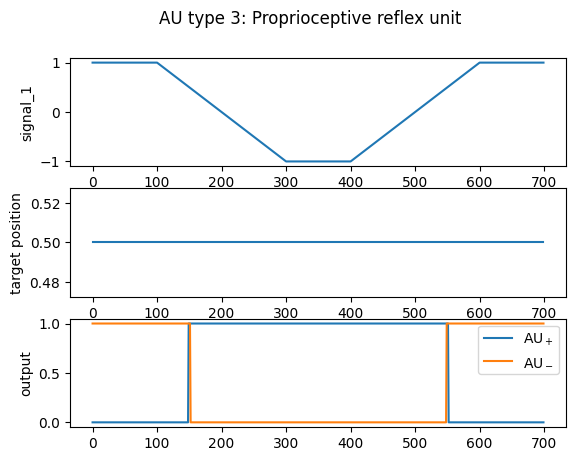

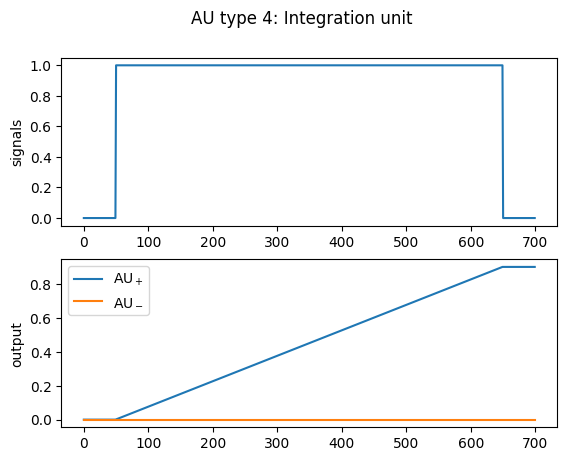

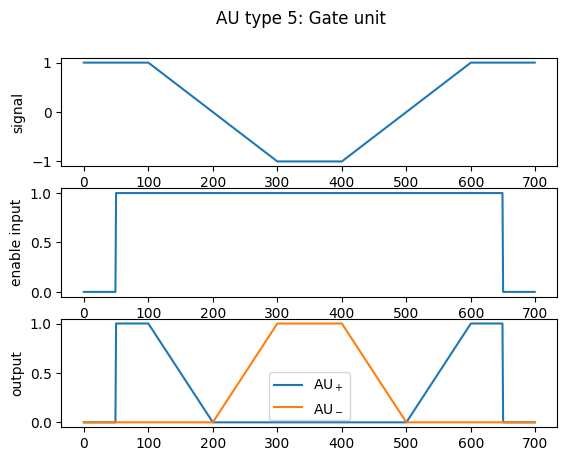

In [1]:
import torch, sys
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

class AdaptionUnit(nn.Module):
	def __init__(
		self,
		alpha=0.5,
		beta=(0.0, 0.0),
		w_fb0_pos=0.1,
		w_fb0_neg=0.1,
		w_ai_pos=1.0,
		w_ai_neg=-1.0,
		w_fb=0.5,
		activation='relu',
		device=None
	):
		super(AdaptionUnit, self).__init__()

		# parameters
		self.alpha = nn.Parameter(torch.tensor(alpha))
		self.beta = nn.Parameter(torch.tensor(beta))  # shape (2,)

		self.w_fb0_pos = nn.Parameter(torch.tensor(w_fb0_pos))
		self.w_fb0_neg = nn.Parameter(torch.tensor(w_fb0_neg))
		self.w_ai_pos  = nn.Parameter(torch.tensor(w_ai_pos))
		self.w_ai_neg  = nn.Parameter(torch.tensor(w_ai_neg))
		self.w_fb      = nn.Parameter(torch.tensor(w_fb))

		# Activation function
		if activation == 'relu':
			self.activation = F.relu
		elif activation == 'tanh':
			self.activation = torch.tanh
		elif activation == 'sigmoid':
			self.activation = torch.sigmoid
		elif activation == 'threshold':
			self.activation = nn.Threshold(0,0.0)
		elif activation == 'step':
			self.activation = lambda x: torch.where(
        x > 0.0, torch.tensor(1.0, device=x.device), torch.tensor(0.0, device=x.device)
      )
		else:
			raise ValueError(f"Unsupported activation: {activation}")

		# Initial state (2 neurons per AU)
		self.device = device if device is not None else torch.device("cpu")
		self.register_buffer('state', torch.zeros(2, device=self.device))

	def reset_state(self):
		self.state.zero_()

	def forward(self, aii_j):
		"""
		Args:
			aii_j: Tensor of shape (3,) = [fb0, ai, fb1]
		Returns:
			aui_j[t+1]: Tensor of shape (2,)
		"""
		# Construct W^{AU}
		W = torch.stack([
			torch.stack([self.w_fb0_pos, self.w_ai_pos,  self.w_fb]),    # for aui_j+
			torch.stack([self.w_fb,      self.w_ai_neg, self.w_fb0_neg]) # for aui_j-
		])

		# Weighted input from current timestep
		weighted_input = W @ aii_j  # shape (2,)
		recurrent_term = self.alpha * self.state  # shape (2,)


		# For debugging
		# print("mapping weight",W)
		# print("inputs",aii_j)
		# print("weighted input",weighted_input)

		# Update AU state
		self.state = self.activation(recurrent_term + weighted_input + self.beta)
		return self.state

# === Run test if main ===
if __name__ == "__main__":

	# ---------------------     AU type 1: forward unit     ----------------------

	# create au
	forward_unit = AdaptionUnit(alpha=0.0,beta=(0.0, 0.0),w_fb=0.0,activation='threshold',w_fb0_pos=0.0,w_fb0_neg=0.0,w_ai_pos=1.0,w_ai_neg=0.0)

	# generate input signal
	signals = np.array([1.0]*100+list(np.arange(1.0,0.0,-0.01))+[0.0]*100+list(np.arange(0.0,1.0,0.01))+[1.0]*100)
	enable_inputs = np.array([0.0]*700)

  # run au
	outputs = np.zeros((signals.shape[0],2))
	for t in range(signals.shape[0]):
		input_vector = torch.FloatTensor([enable_inputs[t], signals[t], enable_inputs[t]])  # [fb0, ai, fb1]
		outputs[t] = forward_unit(input_vector).detach().numpy()

	# visualization
	plt.figure(1)
	plt.suptitle("AU type 1: forward unit")

	plt.subplot(2,1,1)
	plt.plot(signals)
	plt.ylabel('signal')

	# plt.subplot(3,1,2)
	# plt.plot(enable_inputs)
	# plt.ylabel('enable input')

	plt.subplot(2,1,2)
	plt.plot(outputs)
	plt.ylabel('output')
	plt.legend([r'AU$_+$',r'AU$_-$'])
	print("****************************************************************************************************")

# --------------     AU type 2: Exteroceptive Reflex unit     ----------------

	# create au
	# generate input signal
	# run au
	# visualization

# create au
	reflex_unit = AdaptionUnit(activation='step',w_ai_pos=10.0,w_ai_neg=10.0,w_fb0_pos=1.0,w_fb0_neg=1.0,w_fb=-1.0,alpha=0.0,beta=(-10.01, -10.01))

	# generate input signal
	signals_1 = np.array([1.0]*100+list(np.arange(1.0,-1.0,-0.01))+[-1.0]*100+list(np.arange(-1.0,1.0,0.01))+[1.0]*100)
	signals_2= np.array([-1.0]*100+list(np.arange(-1.0,1.0,0.01))+[1.0]*100+list(np.arange(1.0,-1.0,-0.01))+[-1.0]*100)
	enable_inputs = np.array([0.0]*50+[1.0]*600+[0.0]*50)

  # run au
	outputs = np.zeros((signals_1.shape[0],2))
	for t in range(signals_1.shape[0]):
		input_vector = torch.FloatTensor([signals_1[t], enable_inputs[t], signals_2[t]])  # [fb0, ai, fb1]
		outputs[t] = reflex_unit(input_vector).detach().numpy()

	# visualization
	plt.figure(2)
	plt.suptitle("AU type 2: Exteroceptive reflex unit")

	plt.subplot(4,1,1)
	plt.plot(signals_1)
	plt.ylabel('signal_1')

	plt.subplot(4,1,2)
	plt.plot(signals_2)
	plt.ylabel('signal_2')

	plt.subplot(4,1,3)
	plt.plot(enable_inputs)
	plt.ylabel('enable input')

	plt.subplot(4,1,4)
	plt.plot(outputs)
	plt.ylabel('output')
	plt.legend([r'AU$_+$',r'AU$_-$'])


# --------------     AU type 3: Proprioceptive Reflex unit     ----------------

	# create au
	# generate input signal
	# run au
	# visualization

# create au
	reflex_unit_2 = AdaptionUnit(activation='step',w_ai_pos=0.5,w_ai_neg=-0.5,w_fb0_pos=-1.0,w_fb0_neg=1.0,w_fb=0.0,alpha=0.0,beta=(0.01, 0.01))

	# generate input signal
	signals_1 = np.array([1.0]*100+list(np.arange(1.0,-1.0,-0.01))+[-1.0]*100+list(np.arange(-1.0,1.0,0.01))+[1.0]*100)
	# signals_2= np.array([-1.0]*100+list(np.arange(-1.0,1.0,0.01))+[1.0]*100+list(np.arange(1.0,-1.0,-0.01))+[-1.0]*100)
	signals_2= np.array([0.5]*700)
# np.array([1.0]*100+list(np.arange(1.0,-1.0,-0.01))+[-1.0]*100+list(np.arange(-1.0,1.0,0.01))+[1.0]*100)
	enable_inputs = np.array([1.0]*700)

  # run au
	outputs = np.zeros((signals_1.shape[0],2))
	for t in range(signals_1.shape[0]):
		input_vector = torch.FloatTensor([signals_1[t], enable_inputs[t], signals_1[t]])  # [fb0, ai, fb1]
		outputs[t] = reflex_unit_2(input_vector).detach().numpy()

	# visualization
	plt.figure(3)
	plt.suptitle("AU type 3: Proprioceptive reflex unit")

	plt.subplot(3,1,1)
	plt.plot(signals_1)
	plt.ylabel('signal_1')

	plt.subplot(3,1,2)
	plt.plot(signals_2)
	plt.ylabel('target position')

	plt.subplot(3,1,3)
	plt.plot(outputs)
	plt.ylabel('output')
	plt.legend([r'AU$_+$',r'AU$_-$'])

	# -----------------------     AU type 4: Integration unit     -----------------------

	# create au
	integrate_unit = AdaptionUnit(alpha=1.0,beta=(0.0, 0.0),w_fb=0.0,activation='threshold',w_fb0_pos=0.0,w_fb0_neg=0.0,w_ai_pos=0.0015,w_ai_neg=0.0)

	# generate input signal
	# signals = np.array([1.0]*100+list(np.arange(1.0,0.0,-0.01))+[0.0]*100+list(np.arange(0.0,1.0,0.01))+[1.0]*100)
	signals = np.array([0.0]*50+[1.0]*600+[0.0]*50)

  # run au
	outputs = np.zeros((signals.shape[0],2))
	for t in range(signals.shape[0]):
		input_vector = torch.FloatTensor([0, signals[t], 0])  # [fb0, ai, fb1]
		outputs[t] = integrate_unit(input_vector).detach().numpy()

	# visualization
	plt.figure(4)
	plt.suptitle("AU type 4: Integration unit")

	plt.subplot(2,1,1)
	plt.plot(signals)
	plt.ylabel('signals')

	# plt.subplot(3,1,2)
	# plt.plot(enable_inputs)
	# plt.ylabel('enable input')

	plt.subplot(2,1,2)
	plt.plot(outputs)
	plt.ylabel('output')
	plt.legend([r'AU$_+$',r'AU$_-$'])

	# -----------------------     AU type 5: gait unit     -----------------------

	# create au
	gate_unit = AdaptionUnit(alpha=0.0,beta=(-1.0, -1.0),w_fb=0.0,activation='threshold',w_fb0_pos=1.0,w_fb0_neg=1.0,w_ai_pos=1.0,w_ai_neg=-1.0)

	# generate input signal
	signals = np.array([1.0]*100+list(np.arange(1.0,-1.0,-0.01))+[-1.0]*100+list(np.arange(-1.0,1.0,0.01))+[1.0]*100)
	enable_inputs = np.array([0.0]*50+[1.0]*600+[0.0]*50)

  # run au
	outputs = np.zeros((signals.shape[0],2))
	for t in range(signals.shape[0]):
		input_vector = torch.FloatTensor([enable_inputs[t], signals[t], enable_inputs[t]])  # [fb0, ai, fb1]
		outputs[t] = gate_unit(input_vector).detach().numpy()

	# visualization
	plt.figure(5)
	plt.suptitle("AU type 5: Gate unit")

	plt.subplot(3,1,1)
	plt.plot(signals)
	plt.ylabel('signal')

	plt.subplot(3,1,2)
	plt.plot(enable_inputs)
	plt.ylabel('enable input')

	plt.subplot(3,1,3)
	plt.plot(outputs)
	plt.ylabel('output')
	plt.legend([r'AU$_+$',r'AU$_-$'])




plt.show()